In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import seaborn
from multiprocessing import Pool
from matplotlib.patches import Rectangle


sys.path.append("../functions")

from Utils import *
from Plotting import *
from Fitting import *
from Forward import *
from Backward import *


%matplotlib inline

# plt.style.use("../matplotlib_style.txt")

# 1. Read Data

In [3]:
chance_level_subjects = [45634, 46069, 46279, 46303, 46651, 47398]
lv_induction_data = preprocess_data("../data/twoArmedandit_with_confidence.csv", chance_level_subjects, "induction", "hc")
subjects = lv_induction_data["sub"].unique()
n_fitting = 120
n_threads = 100

## 2. Add Noise To Agents

In [4]:
def add_noise_to_conf(confs, mean,std):
    confs_cloned = confs.copy()
    noises =  np.random.normal(loc=mean, scale=std, size= len(confs))
    confs_cloned += noises
    confs_cloned[confs_cloned > 5] = 5
    confs_cloned[confs_cloned <1] =1
    return confs_cloned

In [6]:
high_syn_df = lv_induction_data.copy()
high_syn_df["cj"] = np.where(high_syn_df["cor"] == 1, 5, 1)

In [7]:
params_ranges = [[0, 1], [0, 100], [1, 5], [0, 1]]
n_fitting = 120
n_threads = 100

res = fit_for_all_subjects_parallel(
    params_ranges, n_threads, n_fitting, subjects, high_syn_df, forward_fitting, True
)

hsyn_forward_df = make_df_after_fitting(
    res, ["alpha", "beta", "lbound", "bound_range"], subjects
)
hsyn_forward_df["hbound"] = (5 - hsyn_forward_df["lbound"]) * (
    hsyn_forward_df["bound_range"]
) + hsyn_forward_df["lbound"]

In [16]:
forward_df = pd.read_csv("../results/forward_df.csv")
forward_simulation_df = pd.read_csv("../results/forward_simulation_df.csv")
fwd_avg_df = (
    forward_simulation_df.rename(columns={"sub": "subject"})
    .groupby("subject")
    .agg({"reward": "mean", "cor": "mean", "cj": "mean"})
    .reset_index()
)

In [9]:
noise_std_ls = np.linspace(0, 4, 10)

In [10]:
def add_noise_and_fit(noise_std, df, n_iter=20):
    params_df_list, simulations_df_list = [], []
    for i in range(n_iter):
        if i % 5 == 0:
            print(f"Iteration: {i}, Noise Std: {noise_std}")
        # Add noise to 'cj' column
        noisy_df = df.copy()
        noisy_df["cj"] = add_noise_to_conf(noisy_df["cj"], 0, noise_std)
        
        # Fit models with the noisy data
        res = fit_for_all_subjects_parallel(params_ranges, n_threads, n_fitting, subjects, noisy_df, fit_model_backward, True)
        noise_params = make_df_after_fitting(res, ["alpha", "beta", "lbound", "bound_range"], subjects)
        noise_params["hbound"] = (5 - noise_params["lbound"]) * noise_params["bound_range"] + noise_params["lbound"]
        noise_params["agent_nr"] = i
        noise_params["noise"] = noise_std
        params_df_list.append(noise_params)
        
        # Simulate with the fitted parameters
        noise_simulation = simulate_with_params(noise_params, lv_induction_data, subjects, n=100)
        noise_simulation["agent_nr"] = i
        noise_simulation["noise"] = noise_std
        simulations_df_list.append(noise_simulation)
    
    return pd.concat(params_df_list, ignore_index=True), pd.concat(simulations_df_list, ignore_index=True)

# Loop through different noise levels and collect results
results = [add_noise_and_fit(noise_std, high_syn_df) for noise_std in noise_std_ls]

# Unpack results into DataFrames
noise_params_dfs, noise_simulations_dfs = zip(*results)
noise_params = pd.concat(noise_params_dfs, ignore_index=True)
noise_simulations = pd.concat(noise_simulations_dfs, ignore_index=True)

noise_params_dfs.to_csv("../results/noise_params.csv")
noise_avg_sim = (
    noise_simulations.groupby(["sub", "noise"]).mean(["cor"]).reset_index()
)
noise_avg_sim.to_csv("../results/noise_avg_sim.csv")


Iteration: 0, Noise Std: 0.0


Process ForkPoolWorker-199:
Process ForkPoolWorker-200:
Process ForkPoolWorker-192:
Process ForkPoolWorker-198:
Process ForkPoolWorker-189:
Process ForkPoolWorker-187:
Process ForkPoolWorker-191:
Process ForkPoolWorker-190:
Process ForkPoolWorker-197:
Process ForkPoolWorker-162:
Process ForkPoolWorker-167:
Process ForkPoolWorker-169:
Process ForkPoolWorker-188:
Process ForkPoolWorker-176:
Process ForkPoolWorker-185:
Process ForkPoolWorker-170:
Process ForkPoolWorker-177:
Process ForkPoolWorker-161:
Process ForkPoolWorker-163:
Process ForkPoolWorker-158:
Process ForkPoolWorker-166:
Process ForkPoolWorker-196:
Process ForkPoolWorker-164:
Process ForkPoolWorker-194:
Process ForkPoolWorker-155:
Process ForkPoolWorker-182:
Process ForkPoolWorker-165:
Process ForkPoolWorker-179:
Process ForkPoolWorker-183:
Process ForkPoolWorker-174:
Process ForkPoolWorker-160:
Process ForkPoolWorker-168:
Process ForkPoolWorker-175:
Process ForkPoolWorker-159:
Process ForkPoolWorker-178:
Process ForkPoolWork

  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.8/multiprocessing/proce

  File "/usr/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get

  File "/usr/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/usr/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.8/multiprocessing/synchronize.py", line 95, in _

  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/local/lib/python3.8/dist-packages/scipy/optimize/_lbfgsb_py.py", line 362, in _minimize_lbfgsb
    f, g = func_and_grad(x)
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "

  File "/usr/local/lib/python3.8/dist-packages/scipy/optimize/_lbfgsb_py.py", line 362, in _minimize_lbfgsb
    f, g = func_and_grad(x)
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/local/lib/python3.8/dist-packages/scipy/optimize/_lbfgsb_py.py", line 362, in _minimize_lbfgsb
    f, g = func_and_grad(x)
  File "/usr/local/lib/python3.8/dist-packages/scipy/optimize/_lbfgsb_py.py", line 362, in _minimize_lbfgsb
    f, g = func_and_grad(x)
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.8/dist-packages/scipy/optimize/_numdiff.py", line 505, in approx_derivative
    return _dense_difference(fun_wrapped, x0, f0, h,
  File "/usr/local/lib/python3.8/dist-packages/scipy/optimi

  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/local/lib/python3.8/dist-packages/scipy/optimize/_differentiable_functions.py", line 256, in _update_grad
    self._update_grad_impl()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.8/mu

  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/usr/lib/python3.8

  File "/usr/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/home/agholamzadeh/jupyter/Meta_meassure_refactor/notebooks/../functions/Backward.py", line 40, in fit_model_backward
    result = minimize(backward_distance, initial_params, args=(resps, rewards, confs, scale), bounds=params_ranges)
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/home/agholamzadeh/jupyter/Meta_meassure_refactor/notebooks/../functions/Backward.py", line 40, in fit_model_backward
    result = minimize(backward_distance, initial_params, args=(resps, rewards, confs, scale), bounds=params_ranges)
  File "/home/agholamzadeh/jupyter/Meta_meassure_refactor/notebooks/../functions/Backward.py", line 40, in fit_model_backward
    result = minimize(backward_distance, initial_params, args=(resps, rewards, confs, s

  File "/usr/local/lib/python3.8/dist-packages/scipy/optimize/_minimize.py", line 699, in minimize
    res = _minimize_lbfgsb(fun, x0, args, jac, bounds,
  File "/home/agholamzadeh/jupyter/Meta_meassure_refactor/notebooks/../functions/Backward.py", line 40, in fit_model_backward
    result = minimize(backward_distance, initial_params, args=(resps, rewards, confs, scale), bounds=params_ranges)
  File "/usr/local/lib/python3.8/dist-packages/scipy/optimize/_minimize.py", line 699, in minimize
    res = _minimize_lbfgsb(fun, x0, args, jac, bounds,
  File "/home/agholamzadeh/jupyter/Meta_meassure_refactor/notebooks/../functions/Backward.py", line 40, in fit_model_backward
    result = minimize(backward_distance, initial_params, args=(resps, rewards, confs, scale), bounds=params_ranges)
  File "/home/agholamzadeh/jupyter/Meta_meassure_refactor/notebooks/../functions/Backward.py", line 40, in fit_model_backward
    result = minimize(backward_distance, initial_params, args=(resps, rewards, con

  File "/usr/local/lib/python3.8/dist-packages/scipy/optimize/_minimize.py", line 699, in minimize
    res = _minimize_lbfgsb(fun, x0, args, jac, bounds,
  File "/usr/local/lib/python3.8/dist-packages/scipy/optimize/_minimize.py", line 699, in minimize
    res = _minimize_lbfgsb(fun, x0, args, jac, bounds,
  File "/usr/local/lib/python3.8/dist-packages/scipy/optimize/_minimize.py", line 699, in minimize
    res = _minimize_lbfgsb(fun, x0, args, jac, bounds,
  File "/usr/local/lib/python3.8/dist-packages/scipy/optimize/_minimize.py", line 699, in minimize
    res = _minimize_lbfgsb(fun, x0, args, jac, bounds,
  File "/usr/local/lib/python3.8/dist-packages/scipy/optimize/_lbfgsb_py.py", line 362, in _minimize_lbfgsb
    f, g = func_and_grad(x)
  File "/usr/local/lib/python3.8/dist-packages/scipy/optimize/_minimize.py", line 699, in minimize
    res = _minimize_lbfgsb(fun, x0, args, jac, bounds,
  File "/usr/local/lib/python3.8/dist-packages/scipy/optimize/_minimize.py", line 699, in mini

  File "/usr/local/lib/python3.8/dist-packages/scipy/optimize/_lbfgsb_py.py", line 362, in _minimize_lbfgsb
    f, g = func_and_grad(x)
  File "/usr/local/lib/python3.8/dist-packages/scipy/optimize/_differentiable_functions.py", line 286, in fun_and_grad
    self._update_grad()
  File "/usr/local/lib/python3.8/dist-packages/scipy/optimize/_lbfgsb_py.py", line 362, in _minimize_lbfgsb
    f, g = func_and_grad(x)
  File "/usr/local/lib/python3.8/dist-packages/scipy/optimize/_differentiable_functions.py", line 286, in fun_and_grad
    self._update_grad()
  File "/usr/local/lib/python3.8/dist-packages/scipy/optimize/_lbfgsb_py.py", line 362, in _minimize_lbfgsb
    f, g = func_and_grad(x)
  File "/usr/local/lib/python3.8/dist-packages/scipy/optimize/_differentiable_functions.py", line 286, in fun_and_grad
    self._update_grad()
  File "/usr/local/lib/python3.8/dist-packages/scipy/optimize/_lbfgsb_py.py", line 362, in _minimize_lbfgsb
    f, g = func_and_grad(x)
  File "/usr/local/lib/pyth

  File "/usr/local/lib/python3.8/dist-packages/scipy/optimize/_differentiable_functions.py", line 256, in _update_grad
    self._update_grad_impl()
  File "/usr/local/lib/python3.8/dist-packages/scipy/optimize/_differentiable_functions.py", line 286, in fun_and_grad
    self._update_grad()
  File "/usr/local/lib/python3.8/dist-packages/scipy/optimize/_differentiable_functions.py", line 286, in fun_and_grad
    self._update_grad()
  File "/usr/local/lib/python3.8/dist-packages/scipy/optimize/_differentiable_functions.py", line 286, in fun_and_grad
    self._update_grad()
  File "/usr/local/lib/python3.8/dist-packages/scipy/optimize/_differentiable_functions.py", line 256, in _update_grad
    self._update_grad_impl()
  File "/usr/local/lib/python3.8/dist-packages/scipy/optimize/_differentiable_functions.py", line 286, in fun_and_grad
    self._update_grad()
  File "/usr/local/lib/python3.8/dist-packages/scipy/optimize/_differentiable_functions.py", line 256, in _update_grad
    self._upd

  File "/usr/local/lib/python3.8/dist-packages/scipy/optimize/_differentiable_functions.py", line 256, in _update_grad
    self._update_grad_impl()
  File "/usr/local/lib/python3.8/dist-packages/scipy/optimize/_differentiable_functions.py", line 173, in update_grad
    self.g = approx_derivative(fun_wrapped, self.x, f0=self.f,
  File "/usr/local/lib/python3.8/dist-packages/scipy/optimize/_differentiable_functions.py", line 173, in update_grad
    self.g = approx_derivative(fun_wrapped, self.x, f0=self.f,
  File "/usr/local/lib/python3.8/dist-packages/scipy/optimize/_differentiable_functions.py", line 256, in _update_grad
    self._update_grad_impl()
  File "/usr/local/lib/python3.8/dist-packages/scipy/optimize/_differentiable_functions.py", line 256, in _update_grad
    self._update_grad_impl()
  File "/usr/local/lib/python3.8/dist-packages/scipy/optimize/_differentiable_functions.py", line 155, in update_fun
    self.f = fun_wrapped(self.x)
  File "/usr/local/lib/python3.8/dist-packag

  File "/usr/local/lib/python3.8/dist-packages/scipy/optimize/_numdiff.py", line 505, in approx_derivative
    return _dense_difference(fun_wrapped, x0, f0, h,
  File "/usr/local/lib/python3.8/dist-packages/scipy/optimize/_numdiff.py", line 505, in approx_derivative
    return _dense_difference(fun_wrapped, x0, f0, h,
  File "/usr/local/lib/python3.8/dist-packages/scipy/optimize/_differentiable_functions.py", line 173, in update_grad
    self.g = approx_derivative(fun_wrapped, self.x, f0=self.f,
  File "/usr/local/lib/python3.8/dist-packages/scipy/optimize/_differentiable_functions.py", line 173, in update_grad
    self.g = approx_derivative(fun_wrapped, self.x, f0=self.f,
  File "/usr/local/lib/python3.8/dist-packages/scipy/optimize/_differentiable_functions.py", line 137, in fun_wrapped
    fx = fun(np.copy(x), *args)
  File "/usr/local/lib/python3.8/dist-packages/scipy/optimize/_differentiable_functions.py", line 137, in fun_wrapped
    fx = fun(np.copy(x), *args)
  File "/usr/local

  File "/usr/local/lib/python3.8/dist-packages/scipy/optimize/_numdiff.py", line 576, in _dense_difference
    df = fun(x) - f0
  File "/home/agholamzadeh/jupyter/Meta_meassure_refactor/notebooks/../functions/Backward.py", line 21, in backward_distance
    probabilities = calculate_choice_probabilities(Q, beta, resps, rewards, alpha)
  File "/usr/local/lib/python3.8/dist-packages/scipy/optimize/_numdiff.py", line 505, in approx_derivative
    return _dense_difference(fun_wrapped, x0, f0, h,
  File "/usr/local/lib/python3.8/dist-packages/scipy/optimize/_differentiable_functions.py", line 137, in fun_wrapped
    fx = fun(np.copy(x), *args)
  File "/usr/local/lib/python3.8/dist-packages/scipy/optimize/_numdiff.py", line 576, in _dense_difference
    df = fun(x) - f0
  File "/usr/local/lib/python3.8/dist-packages/scipy/optimize/_differentiable_functions.py", line 137, in fun_wrapped
    fx = fun(np.copy(x), *args)
  File "/usr/local/lib/python3.8/dist-packages/scipy/optimize/_numdiff.py", 

  File "/usr/local/lib/python3.8/dist-packages/scipy/optimize/_numdiff.py", line 576, in _dense_difference
    df = fun(x) - f0
  File "/usr/local/lib/python3.8/dist-packages/scipy/optimize/_numdiff.py", line 456, in fun_wrapped
    f = np.atleast_1d(fun(x, *args, **kwargs))
  File "/usr/local/lib/python3.8/dist-packages/scipy/optimize/_differentiable_functions.py", line 137, in fun_wrapped
    fx = fun(np.copy(x), *args)
  File "/usr/local/lib/python3.8/dist-packages/scipy/optimize/_numdiff.py", line 576, in _dense_difference
    df = fun(x) - f0
  File "/usr/local/lib/python3.8/dist-packages/scipy/optimize/_numdiff.py", line 456, in fun_wrapped
    f = np.atleast_1d(fun(x, *args, **kwargs))
  File "/usr/local/lib/python3.8/dist-packages/scipy/optimize/_numdiff.py", line 456, in fun_wrapped
    f = np.atleast_1d(fun(x, *args, **kwargs))
  File "/usr/local/lib/python3.8/dist-packages/scipy/optimize/_numdiff.py", line 456, in fun_wrapped
    f = np.atleast_1d(fun(x, *args, **kwargs))
  

  File "/home/agholamzadeh/jupyter/Meta_meassure_refactor/notebooks/../functions/Backward.py", line 21, in backward_distance
    probabilities = calculate_choice_probabilities(Q, beta, resps, rewards, alpha)
  File "/usr/local/lib/python3.8/dist-packages/scipy/optimize/_differentiable_functions.py", line 137, in fun_wrapped
    fx = fun(np.copy(x), *args)
  File "/usr/local/lib/python3.8/dist-packages/scipy/optimize/_differentiable_functions.py", line 137, in fun_wrapped
    fx = fun(np.copy(x), *args)
  File "/home/agholamzadeh/jupyter/Meta_meassure_refactor/notebooks/../functions/Utils.py", line 19, in softmax_func
    TdQ = -beta * (Q[0] - Q[1])
  File "/home/agholamzadeh/jupyter/Meta_meassure_refactor/notebooks/../functions/Utils.py", line 12, in softmax_func
    log_max_float = np.log(sys.float_info.max / 2.1)
  File "/usr/local/lib/python3.8/dist-packages/scipy/optimize/_differentiable_functions.py", line 137, in fun_wrapped
    fx = fun(np.copy(x), *args)
  File "/usr/local/lib/

  File "/home/agholamzadeh/jupyter/Meta_meassure_refactor/notebooks/../functions/Backward.py", line 21, in backward_distance
    probabilities = calculate_choice_probabilities(Q, beta, resps, rewards, alpha)
  File "/home/agholamzadeh/jupyter/Meta_meassure_refactor/notebooks/../functions/Backward.py", line 21, in backward_distance
    probabilities = calculate_choice_probabilities(Q, beta, resps, rewards, alpha)
  File "/home/agholamzadeh/jupyter/Meta_meassure_refactor/notebooks/../functions/Backward.py", line 21, in backward_distance
    probabilities = calculate_choice_probabilities(Q, beta, resps, rewards, alpha)
  File "/home/agholamzadeh/jupyter/Meta_meassure_refactor/notebooks/../functions/Backward.py", line 10, in calculate_choice_probabilities
    choices_probability = softmax_func(Q, beta)
  File "/home/agholamzadeh/jupyter/Meta_meassure_refactor/notebooks/../functions/Backward.py", line 10, in calculate_choice_probabilities
    choices_probability = softmax_func(Q, beta)
  Fi

  File "/home/agholamzadeh/jupyter/Meta_meassure_refactor/notebooks/../functions/Backward.py", line 10, in calculate_choice_probabilities
    choices_probability = softmax_func(Q, beta)
KeyboardInterrupt
  File "/home/agholamzadeh/jupyter/Meta_meassure_refactor/notebooks/../functions/Backward.py", line 10, in calculate_choice_probabilities
    choices_probability = softmax_func(Q, beta)
  File "/home/agholamzadeh/jupyter/Meta_meassure_refactor/notebooks/../functions/Utils.py", line 28, in softmax_func
    P[0] = 1. / (1. + np.exp(TdQ))
  File "/home/agholamzadeh/jupyter/Meta_meassure_refactor/notebooks/../functions/Utils.py", line 28, in softmax_func
    P[0] = 1. / (1. + np.exp(TdQ))
  File "/home/agholamzadeh/jupyter/Meta_meassure_refactor/notebooks/../functions/Utils.py", line 28, in softmax_func
    P[0] = 1. / (1. + np.exp(TdQ))
  File "/home/agholamzadeh/jupyter/Meta_meassure_refactor/notebooks/../functions/Backward.py", line 10, in calculate_choice_probabilities
    choices_prob

KeyboardInterrupt: 

In [11]:
def simulate_fit_and_merge(noise_std_ls, n_iter, hsyn_forward_df, data, subjects, n_fitting, n_threads, n_simulations):
    params_df_list, simulations_df_list = [], []

    for noise_std in noise_std_ls:
        for i in range(n_iter):
            simulated_df = simulate_with_params_one(hsyn_forward_df, data, subjects)
            if i % 5 == 0:
                print(f"Iteration: {i}, Noise Std: {noise_std}")
            
            # Add noise
            noie_df = simulated_df.copy()
            noie_df["cj"] = add_noise_to_conf(noie_df["cj"], 0, noise_std)
            
            # Fit models
            res = fit_for_all_subjects_parallel(params_ranges, n_threads, n_fitting, subjects, noie_df, fit_model_backward, True)
            noise_params = make_df_after_fitting(res, ["alpha", "beta", "lbound", "bound_range"], subjects)
            noise_params["hbound"] = (5 - noise_params["lbound"]) * noise_params["bound_range"] + noise_params["lbound"]
            noise_params["agent_nr"] = i
            noise_params["noise"] = noise_std
            params_df_list.append(noise_params)

            # Simulate with noise-adjusted parameters
            noise_simulation = simulate_with_params(noise_params, data, subjects, n=n_simulations)
            noise_simulation["agent_nr"] = i
            noise_simulation["noise"] = noise_std
            simulations_df_list.append(noise_simulation)

    return pd.concat(params_df_list, ignore_index=True), pd.concat(simulations_df_list, ignore_index=True)

# Assuming all necessary functions and variables are defined
forward_noise_params, forward_noise_simulations = simulate_fit_and_merge(
    noise_std_ls, 20, hsyn_forward_df, lv_induction_data, subjects, 40, 120, 30
)

forward_noise_params.to_csv("../results/forward_noise_params_dfs.csv")
noise_avg_model = (
    forward_noise_simulations.groupby(["sub", "noise"]).mean(["cor"]).reset_index()
)
forward_noise_avg_model.to_csv("../results/forward_noise_avg_model.csv")


Iteration: 0, Noise Std: 0.0
Iteration: 5, Noise Std: 0.0


KeyboardInterrupt: 

# Figures

## Supp Figure 3

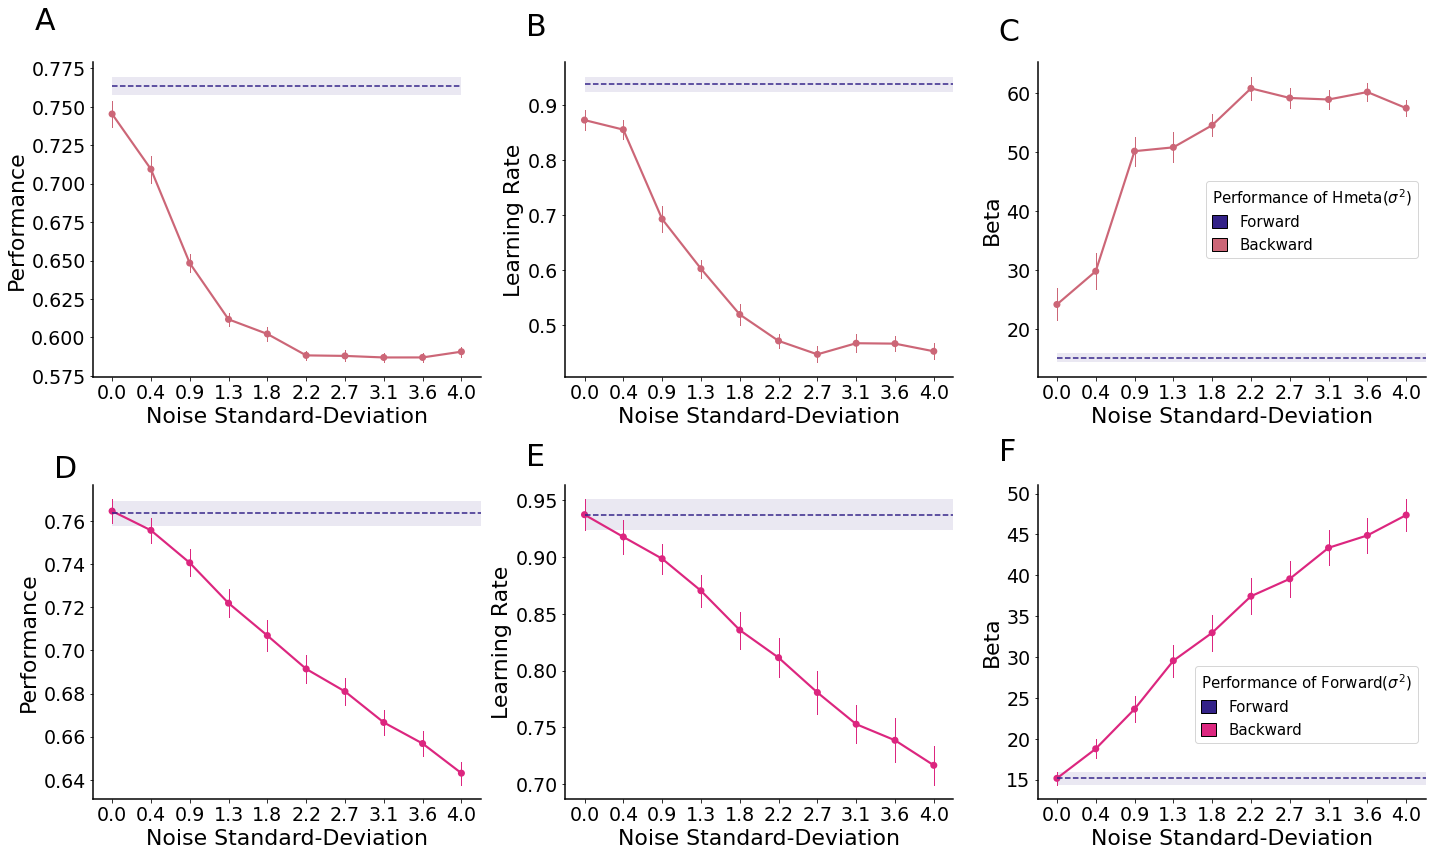

In [19]:
from matplotlib.ticker import FormatStrFormatter

from matplotlib.legend_handler import HandlerTuple


noise_params_dfs = pd.read_csv("../results/noise_params.csv")
noise_avg_sim = pd.read_csv("../results/noise_avg_sim.csv")


fig = plt.figure(figsize=(20, 12))



plt.subplot(2,3,1)




plt.text(-2, .8, "A", fontsize=30)


fwd_averg_perf = fwd_avg_df["cor"].mean()
fwd_averg_perf_se = fwd_avg_df["cor"].sem()

seaborn.pointplot(
    data=noise_avg_sim,
    x="noise",
    y="cor",
    color="#CC6677",
    errwidth=1,
    scale=0.8,
    errorbar="se",
    label="Backward",
    linestyles = ["-"],
    dodge = True
)


plt.axhline(fwd_averg_perf, xmin= .05,xmax = .95, linestyle="--", label="Forward", color="#332288")

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.add_patch(
    Rectangle(
        (0, fwd_averg_perf - fwd_averg_perf_se),
        9,
        2 * fwd_averg_perf_se,
        alpha=0.1,
        ls="",
        color="#332288",
    )
)


# plt.gca().invert_xaxis()


plt.xticks(fontsize=19)
plt.yticks(fontsize=19)


plt.xlabel("Noise Standard-Deviation", fontsize=22)
plt.ylabel("Performance", fontsize=22)

ax.set_xticklabels([0. , 0.4, 0.9, 1.3, 1.8, 2.2, 2.7, 3.1, 3.6, 4. ])




plt.subplot(2,3,2)

plt.text(-1.5, 1.025, "B", fontsize=30)


noise_sub_df_model_1 = (
    noise_params_dfs.groupby(["subject", "noise"]).mean(["alpha"]).reset_index()
)


fwd_averg_perf = forward_df["alpha"].mean()
fwd_averg_perf_se = forward_df["alpha"].sem()

seaborn.pointplot(
    data=noise_sub_df_model_1,
    x="noise",
    y="alpha",
    color="#CC6677",
    errwidth=1,
    scale=0.8,
    errorbar="se",
    label="Backward Model",
)


plt.axhline(fwd_averg_perf, xmin = .05,linestyle="--", label="Forward Model", color="#332288")

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.add_patch(
    Rectangle(
        (0, fwd_averg_perf - fwd_averg_perf_se),
        100,
        2 * fwd_averg_perf_se,
        alpha=0.1,
        ls="",
        color="#332288",
    )
)



plt.xticks(fontsize=19)
plt.yticks(fontsize=19)


plt.xlabel("Noise Standard-Deviation", fontsize=22)
plt.ylabel("Learning Rate", fontsize=22)

ax.set_xticklabels([0. , 0.4, 0.9, 1.3, 1.8, 2.2, 2.7, 3.1, 3.6, 4. ])



plt.subplot(2,3,3)

plt.text(-1.5, 69, "C", fontsize=30)

noise_sub_df_model_1 = (
    noise_params_dfs.groupby(["subject", "noise"]).mean(["beta"]).reset_index()
)


fwd_averg_perf = forward_df["beta"].mean()
fwd_averg_perf_se = forward_df["beta"].sem()

seaborn.pointplot(
    data=noise_sub_df_model_1,
    x="noise",
    y="beta",
    color="#CC6677",
    errwidth=1,
    scale=0.8,
    errorbar="se",
    label="Backward Model",
)

plt.axhline(fwd_averg_perf, xmin = .05,linestyle="--", label="Forward Model", color="#332288")

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.add_patch(
    Rectangle(
        (0, fwd_averg_perf - fwd_averg_perf_se),
        100,
        2 * fwd_averg_perf_se,
        alpha=0.1,
        ls="",
        color="#332288",
    )
)


# plt.gca().invert_xaxis()


plt.xticks(fontsize=19)
plt.yticks(fontsize=19)


plt.xlabel("Noise Standard-Deviation", fontsize=22)
plt.ylabel("Beta", fontsize=22)

ax.set_xticklabels([0. , 0.4, 0.9, 1.3, 1.8, 2.2, 2.7, 3.1, 3.6, 4. ])

legend = plt.legend(fontsize = 18, loc = 5, title = "Performance of Hmeta(sigma^2)", title_fontsize = 18)


handles = []

handles.append(plt.Rectangle((0, 0), 0, 0, facecolor="#332288", edgecolor='black'))
handles.append(plt.Rectangle((0, 0), 0, 0, facecolor="#CC6677", edgecolor='black'))


legend = ax.legend(handles=[tuple(handles[::2]), tuple(handles[1::2])], labels=["Forward", "Backward"], handlelength=1, handleheight = 1,handler_map={tuple: HandlerTuple(ndivide=None, pad=0)}, fontsize = 15
         , loc = "right", title = r"Performance of Hmeta($\sigma^2$)", title_fontsize = 15)
legend._legend_box.align='left'




plt.subplot(2,3,4)

plt.text(-1.5, .78, "D", fontsize=30)


fwd_averg_perf = fwd_avg_df["cor"].mean()
fwd_averg_perf_se = fwd_avg_df["cor"].sem()
noise_sub_df_model1 = pd.read_csv("../results/forward_noise_avg_sim.csv")

seaborn.pointplot(
    data=noise_sub_df_model1,
    x="noise",
    y="cor",
    color="#DC267F",
    errwidth=1,
    scale=0.8,
    errorbar="se",
    label="Backward",
)

plt.axhline(fwd_averg_perf, xmin= .05, linestyle="--", label="Forward", color="#332288")

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.add_patch(
    Rectangle(
        (0, fwd_averg_perf - fwd_averg_perf_se),
        100,
        2 * fwd_averg_perf_se,
        alpha=0.1,
        ls="",
        color="#332288",
    )
)


# plt.gca().invert_xaxis()


plt.xticks(fontsize=19)
plt.yticks(fontsize=19)


plt.xlabel("Noise Standard-Deviation", fontsize=22)
plt.ylabel("Performance", fontsize=22)


ax.set_xticklabels([0. , 0.4, 0.9, 1.3, 1.8, 2.2, 2.7, 3.1, 3.6, 4. ])

plt.subplot(2,3,5)

plt.text(-1.5, .98, "E", fontsize=30)

forward_noise_1_params_model_1 = pd.read_csv("../results/forward_noise_params.csv")

noise_sub_df = (
    forward_noise_1_params_model_1.groupby(["subject", "noise"]).mean(["alpha"]).reset_index()
)

# rounded_df = noise_sub_df.round({"noise_var": 1})


fwd_averg_perf = hsyn_forward_df["alpha"].mean()
fwd_averg_perf_se = hsyn_forward_df["alpha"].sem()


seaborn.pointplot(
    data=noise_sub_df,
    x="noise",
    y="alpha",
    color="#DC267F",
    errwidth=1,
    scale=0.8,
    errorbar="se",
    label="High meta to noisy",
)

plt.axhline(fwd_averg_perf, xmin = .05,  linestyle="--", label="Forward Model", color="#332288")

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.add_patch(
    Rectangle(
        (0, fwd_averg_perf - fwd_averg_perf_se),
        100,
        2 * fwd_averg_perf_se,
        alpha=0.1,
        ls="",
        color="#332288",
    )
)



plt.xticks(fontsize=19)
plt.yticks(fontsize=19)


plt.xlabel("Noise Standard-Deviation", fontsize=22)
plt.ylabel("Learning Rate", fontsize=22)

ax.set_xticklabels([0. , 0.4, 0.9, 1.3, 1.8, 2.2, 2.7, 3.1, 3.6, 4. ])

plt.tight_layout() # Or equivalently,  "plt.tight_layout()"


plt.subplot(2,3,6)

plt.text(-1.5, 54, "F", fontsize=30)

noise_sub_df = (
    forward_noise_1_params_model_1.groupby(["subject", "noise"]).mean(["alpha"]).reset_index()
)

# rounded_df = noise_sub_df.round({"noise_var": 1})

fwd_averg_perf = hsyn_forward_df["beta"].mean()
fwd_averg_perf_se = hsyn_forward_df["beta"].sem()

seaborn.pointplot(
    data=noise_sub_df,
    x="noise",
    y="beta",
    color="#DC267F",
    errwidth=1,
    scale=0.8,
    errorbar="se",
    label="High meta to noisy",
)

plt.axhline(fwd_averg_perf, xmin = .05,linestyle="--", label="Forward Model", color="#332288")

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)


plt.xticks(fontsize=19)
plt.yticks(fontsize=19)

ax.add_patch(
    Rectangle(
        (0, fwd_averg_perf - fwd_averg_perf_se),
        100,
        2 * fwd_averg_perf_se,
        alpha=0.1,
        ls="",
        color="#332288",
    )
)

legend = plt.legend(fontsize = 18, loc = 3, title = "Performance of Forward(sigma^2)", title_fontsize = 18)

legend._legend_box.align='left'

handles = []

handles.append(plt.Rectangle((0, 0), 0, 0, facecolor="#332288", edgecolor='black'))
handles.append(plt.Rectangle((0, 0), 0, 0, facecolor="#DC267F", edgecolor='black'))


legend = ax.legend(handles=[tuple(handles[::2]), tuple(handles[1::2])], labels=["Forward","Backward"], handlelength=1, handleheight = 1, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)}, fontsize = 15
         , loc = "right", bbox_to_anchor=(1, .3), title = r"Performance of Forward($\sigma^2$)", title_fontsize = 15)
legend._legend_box.align='left'



plt.xlabel("Noise Standard-Deviation", fontsize=22)
plt.ylabel("Beta", fontsize=22)


ax.set_xticklabels([0. , 0.4, 0.9, 1.3, 1.8, 2.2, 2.7, 3.1, 3.6, 4. ])


plt.tight_layout() # Or equivalently,  "plt.tight_layout()"

plt.savefig("../figs/supp_fig3.png", dpi=400, bbox_inches = "tight")


plt.show()

## Supp Figure 13

## Supp Figure 14

(p = 2.35e-01, r = -0.16,ci = [-0.41,0.11])
(p = 1.11e-06, r = -0.61,ci = [-0.75,-0.41])
(p = 2.86e-03, r = -0.40,ci = [-0.60,-0.15])
(p = 5.78e-02, r = -0.26,ci = [-0.49,0.01])
(p = 2.37e-01, r = -0.16,ci = [-0.41,0.11])
(p = 3.76e-06, r = -0.58,ci = [-0.74,-0.37])


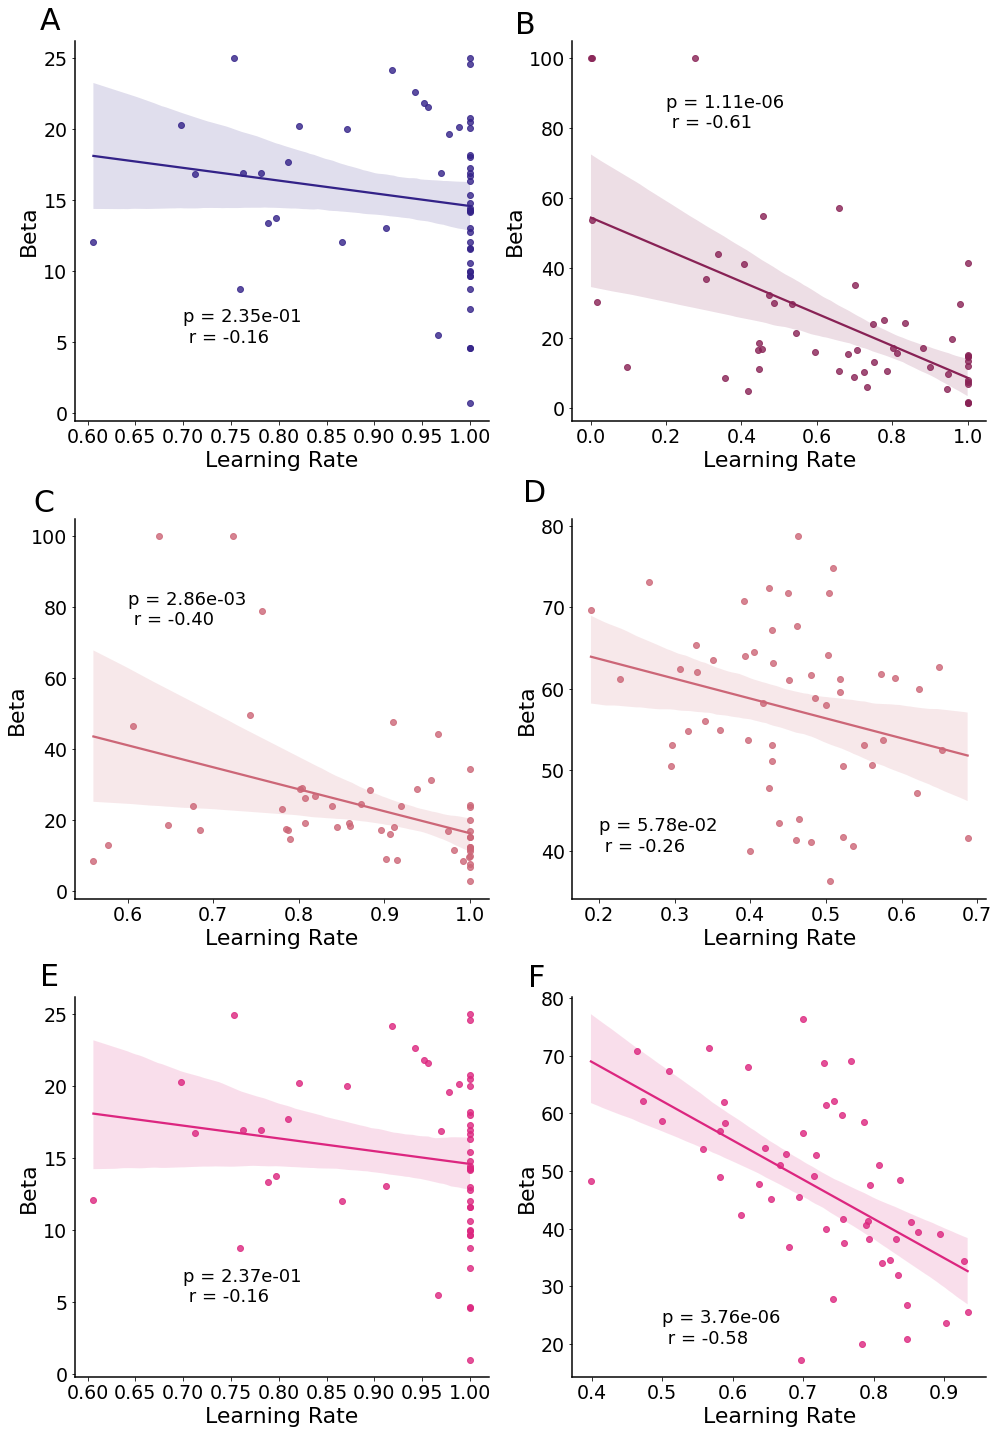

In [26]:
from matplotlib.ticker import StrMethodFormatter

plt.figure(figsize=(14, 20))



plt.subplot(3,2,1)
plt.text(.55, 27, "A", fontsize=30)

forward_df = pd.read_csv("../results/forward_df.csv")
plot_regression_df(forward_df,"alpha", "beta", "#332288", .7, 5, "Learning Rate", "Beta")
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:.2f}')) # 2 decimal places


plt.subplot(3,2,2)
plt.text(-.2, 107, "B", fontsize=30)

backward_df = pd.read_csv("../results/backward_df.csv")
plot_regression_df(backward_df,"alpha", "beta", "#882255", .2, 80, "Learning Rate", "Beta")
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}')) # 2 decimal places

plt.subplot(3,2,3)
plt.text(.49, 107, "C", fontsize=30)

temp_df_noise =noise_1_params_model_1[noise_1_params_model_1["noise"] == 0]
temp_df = temp_df_noise.groupby(["subject"]).mean().reset_index()

plot_regression_df(temp_df,"alpha", "beta", "#CC6677", .6, 75, "Learning Rate", "Beta")


plt.subplot(3,2,4)
plt.text(.1, 83, "D", fontsize=30)

temp_df_noise =noise_1_params_model_1[noise_1_params_model_1["noise"] == 4]
temp_df = temp_df_noise.groupby(["subject"]).mean().reset_index()

plot_regression_df(temp_df,"alpha", "beta", "#CC6677", .2, 40, "Learning Rate", "Beta")


plt.subplot(3,2,5)
plt.text(.55, 27, "E", fontsize=30)

temp_df_noise =forward_noise_1_params_model_1[forward_noise_1_params_model_1["noise"] == 0]
temp_df = temp_df_noise.groupby(["subject"]).mean().reset_index()
plot_regression_df(temp_df,"alpha", "beta", "#DC267F", .7, 5, "Learning Rate", "Beta")


plt.subplot(3,2,6)

plt.text(.31, 82, "F", fontsize=30)


temp_df_noise =forward_noise_1_params_model_1[forward_noise_1_params_model_1["noise"] == 4]
temp_df = temp_df_noise.groupby(["subject"]).mean().reset_index()
plot_regression_df(temp_df,"alpha", "beta", "#DC267F", .5, 20, "Learning Rate", "Beta")



plt.tight_layout()

plt.savefig("../figs/Supp_Figure14.png", dpi=400, bbox_inches = "tight")


plt.show()
